# Demo Code of Chapter 4

## Calculate Gradient of Variational Quantum Circuit

### Construct Variational Quantum Circuit

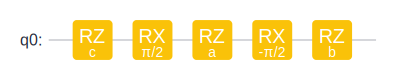

In [1]:
import numpy as np
from mindquantum.core.circuit import Circuit

ansatz = Circuit().rz('c', 0).rx(np.pi/2, 0)
ansatz.rz('a', 0).rx(-np.pi/2, 0).rz('b', 0)
ansatz.svg()

### Construct Observable

In [2]:
from mindquantum.core.operators import QubitOperator, Hamiltonian

obs = QubitOperator('X0')
ham = Hamiltonian(obs)
ham

1 [X0]

### Construct Gradient Operator

In [4]:
import numpy as np
from mindquantum.simulator import Simulator

sim = Simulator('mqvector', ansatz.n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, ansatz)

### Calculate Expectation Value and Gradient

In [5]:
p0 = np.random.uniform(-np.pi , np.pi , len(ansatz.params_name))
f, g = grad_ops(p0)
print(f)
print(g)

[[-0.18777071+0.j]]
[[[2.84377922e-17+0.j 9.05965800e-01+0.j 7.70044917e-02+0.j]]]


### Gradient Based Optimization

In [6]:
from scipy.optimize import minimize

def fun(p0, grad):
    f, g = grad(p0)
    f = np.real(f)[0, 0]
    g = np.real(g)[0, 0]
    return f, g

res = minimize(fun, p0, method='bfgs', jac=True, args=(grad_ops, ))
print('min E: ', res.fun)
print('Best p: ', res.x)

min E:  -0.9999999999999958
Best p:  [ 1.89061189  1.5707963  -3.14159257]


### Get Ansatz Matrix

In [7]:
ansatz.matrix(pr=dict(zip(ansatz.params_name, res.x)))

array([[ 0.57323459+0.41400738j,  0.57323454-0.41400742j],
       [-0.57323454-0.41400742j,  0.57323459-0.41400738j]])

## Rotate Three State

### Construct Encoder

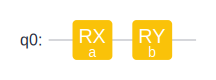

In [13]:
import numpy as np
from mindquantum.core.circuit import Circuit

encoder = Circuit().rx('a', 0).ry('b', 0)
encoder = encoder.as_encoder()
encoder.svg()

In [14]:
e_data = np.array([
    [0.0, 0.0],
    [0.0, np.pi/2],
    [-np.pi/2, 0.0],
])

### Construct Ansatz

Build the arbitrary single qubit rotation ansatz.

In [15]:
from mindquantum.framework import MQLayer
import mindspore.nn as nn
import mindspore as ms

ansatz = Circuit().rz('a2', 0).rx(np.pi/2, 0)
ansatz.rz('a0', 0).rx(-np.pi/2, 0).rz('a1', 0)

obs = QubitOperator('Z0')
ham = Hamiltonian(-obs)

sim = Simulator('mqvector', 1)
total_circ = encoder + ansatz
grad_ops = sim.get_expectation_with_grad(ham, total_circ)

e_tensor = ms.Tensor(e_data, ms.float32)

quantum_net = MQLayer(grad_ops)

class Hybrid(nn.Cell):
    def __init__(self, quantum_net):
        super(Hybrid, self).__init__()
        self.quantum_net = quantum_net
    def construct(self, e):
        x = self.quantum_net(e)
        x = x.sum()
        return x

hybrid = Hybrid(quantum_net)
opti = nn.Adam(quantum_net.trainable_params(), learning_rate=0.1)
train_net = nn.TrainOneStepCell(hybrid, opti)
for step in range(100):
    print(-train_net(e_tensor))

1.002942
1.1078438
1.2143911
1.3209245
1.423695
1.5182176
1.599665
1.6633512
1.705539
1.7248421
1.7241161
1.710918
1.6940937
1.6796803
1.6702311
1.6660006
1.6660355
1.6689276
1.6733861
1.6786413
1.684553
1.6913455
1.6991296
1.7075614
1.7158408
1.7229749
1.7281082
1.7307694
1.730977
1.7292035
1.7262294
1.7229443
1.7201501
1.7184166
1.7180111
1.7188997
1.7208062
1.7233031
1.7259179
1.7282333
1.7299647
1.7309971
1.7313803
1.7312799
1.7309082
1.7304583
1.7300624
1.7297828
1.7296306
1.7295932
1.7296596
1.7298288
1.730103
1.7304716
1.7308997
1.7313292
1.7316916
1.7319288
1.7320127
1.7319529
1.7317938
1.7315993
1.7314337
1.7313434
1.7313468
1.7314336
1.7315733
1.7317269
1.7318599
1.7319522
1.7319982
1.7320061
1.73199
1.7319645
1.7319393
1.73192
1.7319076
1.7319031
1.7319071
1.7319205
1.7319429
1.7319717
1.7320023
1.7320285
1.7320446
1.7320485
1.7320414
1.732028
1.7320137
1.7320039
1.732002
1.732007
1.732017
1.7320282
1.732038
1.7320443
1.7320471
1.7320471
1.7320454
1.7320435


### Plot the Quantum State

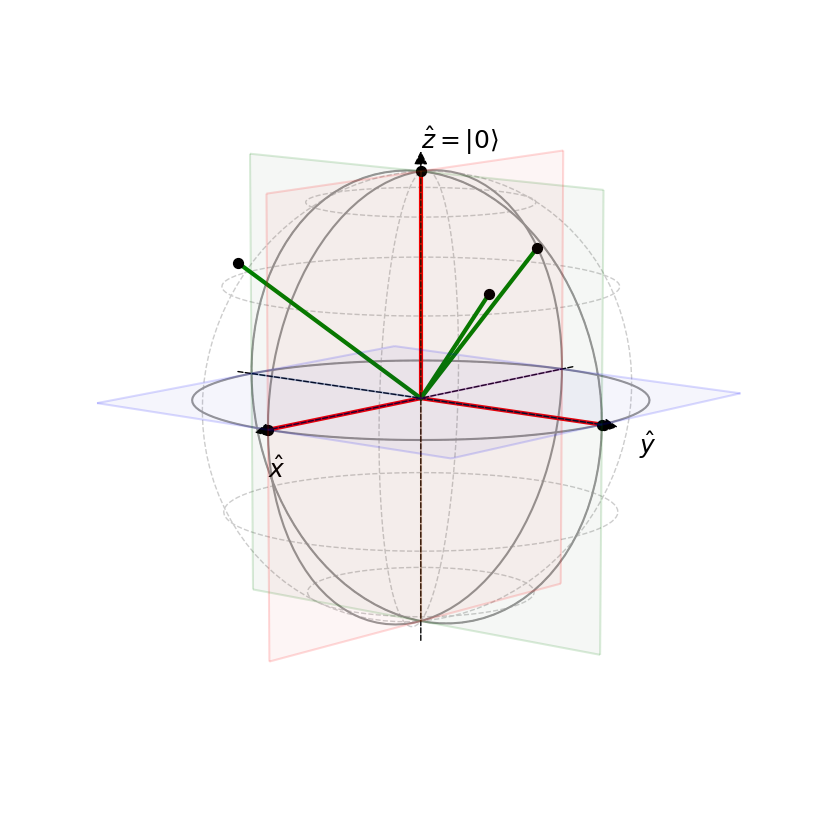

In [16]:
import matplotlib.pyplot as plt
from mindquantum.io import BlochScene
from mindquantum.core.parameterresolver import ParameterResolver as PR

e_name = encoder.params_name
a_name = ansatz.params_name
a_data = np.array(quantum_net.weight)

init_states = [encoder.get_qs(pr=dict(zip(e_name, i))) for i in e_data]
final_states = []
for i, data in enumerate(e_data):
    pr = PR(dict(zip(e_name, data)))
    pr += PR(dict(zip(a_name, a_data)))
    final_states.append(total_circ.get_qs(pr=pr))

scene = BlochScene()
fig, ax = scene.create_scene()

for i in init_states:
    scene.add_state(ax,
        i,
        linecolor='r',
        with_proj=False)

for i in final_states:
    scene.add_state(ax,
        i,
        linecolor='g',
        with_proj=False)

plt.show()

In [17]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy', 'matplotlib')

Software,Version
mindquantum,0.9.0
scipy,1.10.1
numpy,1.21.6
matplotlib,3.5.2
System,Info
Python,3.9.13
OS,Linux x86_64
Memory,16.62 GB
CPU Max Thread,16
Date,Wed Jan 10 18:30:21 2024
